In [1]:
# Imports and setup
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm

In [2]:
# Load data
connections = pd.read_csv("data/connections_princeton_no_threshold.csv.gz")
cell_types = pd.read_csv("data/consolidated_cell_types.csv.gz")

threshold = 3

# Apply minimum synapse filter (threshold = 3)
connections = connections[connections['syn_count'] >= threshold]

print(connections.head())
print(f"Remaining connections: {len(connections)}")

           pre_root_id        post_root_id neuropil  syn_count nt_type
0   720575940625363947  720575940623224444     ME_L         12    GABA
2   720575940630432382  720575940618518557     ME_L         67     ACH
3   720575940627314521  720575940626337738     ME_L         10    GABA
7   720575940620280405  720575940620204726     ME_L         15     ACH
14  720575940608359298  720575940613493733     ME_L          5     ACH
Remaining connections: 6857111


In [3]:
# Plotting functions
def plot_primacy_distribution(df, target_label, max_rank=5):
    """
    Stacked bar plot of primacy distribution (strong vs weak inputs),
    with automatic saving to 'figures/' directory.
    """
    counts = (
        df.groupby(['rank', 'strength'])
          .size()
          .unstack(fill_value=0)
          .reindex(range(1, max_rank+1), fill_value=0)
    )

    # --- Create and style plot ---
    ax = counts.plot(
        kind='bar',
        stacked=True,
        color={'strong':'darkgreen', 'weak':'lightgreen'},
        figsize=(6,4)
    )
    plt.xlabel("Primacy rank of target neuron")
    plt.ylabel("Number of presynaptic cell types")
    plt.title(f"Input primacy distribution for {target_label}")
    plt.xticks(rotation=0)
    plt.tight_layout()

    # --- Ensure 'figures/' directory exists ---
    os.makedirs("figures", exist_ok=True)

    # --- Build filename and save figure ---
    safe_label = target_label.replace(" ", "_")
    fig_path = f"figures/input_primacy_{safe_label}.png"
    plt.savefig(fig_path, dpi=300)
    print(f"✅ Figure saved to: {fig_path}")

    # --- Display inline ---
    plt.show()

In [4]:
# Utility functions
def get_inputs(connections, target_id):
    """
    Return all presynaptic neurons (and their synapse counts) that connect to the target neuron.
    """
    return connections[connections["post_root_id"] == target_id][
        ["pre_root_id", "syn_count"]
    ]


def get_outputs(connections, target_id):
    """
    Return all outputs (postsynaptic partners and synapse counts) of a given neuron.
    """
    return connections[connections["pre_root_id"] == target_id][
        ["post_root_id", "syn_count"]
    ]


def compute_primacy_by_type(
    connections,
    target_id,
    cell_types,
    strong_threshold=100,
    min_syn_count=3,
    verbose=False,
    show_progress=True,
):
    """
    For a target neuron, compute primacy ranking across its input CELL TYPES.

    Additionally, compute the proportion of input types with strong connections
    (>= strong_threshold) for which the target neuron is the *primary* output target.

    Returns
    -------
    results_df : pd.DataFrame
        Columns: input_type, weight_to_target_type, rank, strength
    proportion_primary_strong : float
        Fraction of strong connections whose rank == 1
    """
    # filter at the very beginning
    conn_filt = connections[connections["syn_count"] >= min_syn_count]

    # map neuron IDs → primary_type
    id_to_type = dict(zip(cell_types["root_id"], cell_types["primary_type"]))

    # --- Step 1: collapse inputs by type ---
    inputs = (
        conn_filt[conn_filt["post_root_id"] == target_id]
        .assign(type_pre=lambda df: df["pre_root_id"].map(id_to_type))
        .dropna(subset=["type_pre"])
        .groupby("type_pre", as_index=False)["syn_count"]
        .sum()
        .rename(columns={"syn_count": "weight_to_target"})
        .sort_values("weight_to_target", ascending=False, ignore_index=True)
    )

    primacy_records = []

    # --- Step 2: for each input TYPE, compute rank of target among its outputs ---
    iterator = inputs.iterrows()
    if show_progress:
        iterator = tqdm(
            inputs.iterrows(),
            total=len(inputs),
            desc=f"Analyzing {len(inputs)} input types",
        )

    target_type = cell_types.loc[
        cell_types["root_id"] == target_id, "primary_type"
    ].values[0]

    for _, row in iterator:
        in_type = row["type_pre"]

        # all neurons of this type
        members = cell_types.loc[cell_types["primary_type"] == in_type, "root_id"]

        outputs = (
            conn_filt[conn_filt["pre_root_id"].isin(members)]
            .assign(type_post=lambda df: df["post_root_id"].map(id_to_type))
            .dropna(subset=["type_post"])
            .groupby("type_post", as_index=False)["syn_count"]
            .sum()
            .sort_values("syn_count", ascending=False, ignore_index=True)
        )

        mask = outputs["type_post"] == target_type
        if mask.any():
            pos = outputs.index[mask][0]
            rank = pos + 1
            out_weight = outputs.loc[mask, "syn_count"].values[0]
            primacy_records.append(
                {
                    "input_type": in_type,
                    "weight_to_target_type": out_weight,
                    "rank": rank,
                    "strength": "strong" if out_weight >= strong_threshold else "weak",
                }
            )
        elif verbose:
            print(f"Input type {in_type} → target type {target_type}: not found")

    results_df = pd.DataFrame(primacy_records)

    # --- Step 3: compute proportion of strong connections with rank == 1 ---
    if not results_df.empty:
        strong_df = results_df[results_df["strength"] == "strong"]
        if len(strong_df) > 0:
            proportion_primary_strong = (strong_df["rank"] == 1).mean()
        else:
            proportion_primary_strong = float("nan")
    else:
        proportion_primary_strong = float("nan")

    if verbose:
        print(
            f"Proportion of strong input types where target is primary output: {proportion_primary_strong:.3f}"
        )

    return results_df, proportion_primary_strong

Analyzing 310 input types: 100%|██████████| 310/310 [00:35<00:00,  8.61it/s]


Proportion of strong input types where target is primary output: 0.000
0.00% of strong input types have oviIN Right as their primary output target.
✅ Figure saved to: figures/input_primacy_oviIN_Right.png


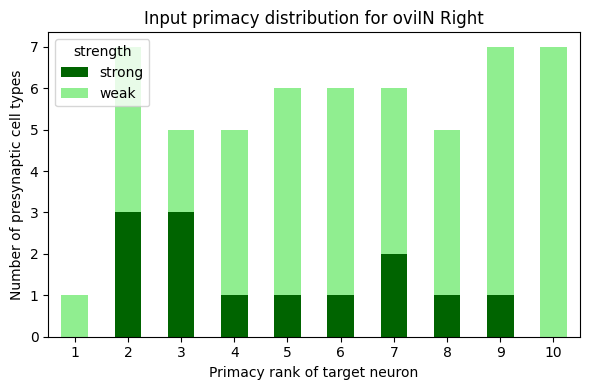

In [5]:
target_id = 720575940625741287
target_label = "oviIN Right"

primacy_df, prop_primary = compute_primacy_by_type(
    connections,
    target_id,
    cell_types=cell_types,
    strong_threshold=100,
    min_syn_count=threshold,
    verbose=True,
)

print(
    f"{prop_primary:.2%} of strong input types have {target_label} as their primary output target."
)

plot_primacy_distribution(primacy_df, target_label, max_rank=10)